# Playground

In [5]:
##### IMPORTS #####
import numpy as np
import pandas as pd
import os.path as osp
import scipy.stats as ss
from tqdm import tqdm
from scipy import stats
from dialect.core import *
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from itertools import combinations

from simulations.run_simulation import *

In [6]:
##### CONSTANTS #####
BASE_DIR = 'results/tcga_pancan_atlas_2018'
SUBTYPE = 'AML'
RESULTS_DIR = osp.join(BASE_DIR, SUBTYPE)

### 🧮 Generating DIALECT p-values from LLR

How do we determine an interaction is significant given its log likelihood ratio statistic estimated from DIALECT?

In [3]:
cnt_mtx_fn = os.path.join(RESULTS_DIR, f"{SUBTYPE}_cbase_cnt_mtx.csv")
bmr_pmfs_fn = os.path.join(RESULTS_DIR, f"{SUBTYPE}_cbase_bmr_pmfs.csv")
cnt_mtx_df = pd.read_csv(cnt_mtx_fn, index_col=0)
bmr_pmfs_df = pd.read_csv(bmr_pmfs_fn, index_col=0)
bmrs_pmfs_dict = bmr_pmfs_df.T.to_dict(orient="list")
bmrs_pmfs_dict = {
    key: [x for x in bmrs_pmfs_dict[key] if not np.isnan(x)] for key in bmrs_pmfs_dict
}

#### Non parametric approach for each gene

In [4]:
# UPDATED ANALYZE SUBCOMMAND CODE TO CALCULATE P VALUES W/ PERMUTATION TEST FOR EACH GENE PAIR

#### Semi parametric approach: find ditribution that best fits data

In [4]:
distributions = [
    ss.norm, ss.expon, ss.gamma, ss.beta, ss.chi2, ss.lognorm, ss.t, ss.weibull_min,
    ss.alpha, ss.betaprime, ss.bradford, ss.exponweib, ss.f, ss.fatiguelife, ss.fisk, ss.foldcauchy,
    ss.genpareto, ss.genexpon, ss.genextreme, ss.geninvgauss, ss.gibrat, ss.gumbel_r, ss.halfcauchy,
    ss.halfgennorm, ss.invgamma, ss.invweibull, ss.kappa3, ss.levy, ss.loglaplace, ss.moyal,
    ss.mielke, ss.lomax, ss.recipinvgauss, ss.wald
]

In [9]:
# DRIVER - DRIVER (LOW - LOW)
gene_a, gene_b = 'TP53_M', 'PIK3CA_M'
ga_pmfs = np.array(bmrs_pmfs_dict[gene_a])
ga_pmfs = ga_pmfs / sum(ga_pmfs)
gb_pmfs = np.array(bmrs_pmfs_dict[gene_b])
gb_pmfs = gb_pmfs / sum(gb_pmfs)
dd_null_llrs, dd_null_log_odds = generate_null_distribution(nsamples=1000, nruns=15000, gene_a_bmr_pmfs=ga_pmfs, gene_b_bmr_pmfs=gb_pmfs)

dd_results = {}
for distribution in distributions:
    params = distribution.fit(dd_null_llrs)
    D, p = ss.kstest(dd_null_llrs, distribution.cdf, args=params)
    dd_results[distribution.name] = D

dd_results_items = list(dd_results.items())
dd_results_items.sort(key=lambda x: x[1])
for x in dd_results_items[:10]:
    print(x)

In [10]:
# DRIVER - PASSENGER (LOW - HIGH)
gene_a, gene_b = 'TP53_M', 'TTN_M'
ga_pmfs = np.array(bmrs_pmfs_dict[gene_a])
ga_pmfs = ga_pmfs / sum(ga_pmfs)
gb_pmfs = np.array(bmrs_pmfs_dict[gene_b])
gb_pmfs = gb_pmfs / sum(gb_pmfs)
dp_null_llrs, dp_null_log_odds = generate_null_distribution(nsamples=1000, nruns=15000, gene_a_bmr_pmfs=ga_pmfs, gene_b_bmr_pmfs=gb_pmfs)

dp_results = {}
for distribution in distributions:
    params = distribution.fit(dp_null_llrs)
    D, p = ss.kstest(dp_null_llrs, distribution.cdf, args=params)
    dp_results[distribution.name] = D

dp_results_items = list(dp_results.items())
dp_results_items.sort(key=lambda x: x[1])
for x in dp_results_items[:10]:
    print(x)

In [11]:
# gene_a, gene_b = 'TTN_M', 'MUC16_M' (HIGH - HIGH)
ga_pmfs = np.array(bmrs_pmfs_dict[gene_a])
ga_pmfs = ga_pmfs / sum(ga_pmfs)
gb_pmfs = np.array(bmrs_pmfs_dict[gene_b])
gb_pmfs = gb_pmfs / sum(gb_pmfs)
pp_null_llrs, pp_null_log_odds = generate_null_distribution(nsamples=1000, nruns=15000, gene_a_bmr_pmfs=ga_pmfs, gene_b_bmr_pmfs=gb_pmfs)

pp_results = {}
for distribution in distributions:
    params = distribution.fit(pp_null_llrs)
    D, p = ss.kstest(pp_null_llrs, distribution.cdf, args=params)
    pp_results[distribution.name] = D

pp_results_items = list(pp_results.items())
pp_results_items.sort(key=lambda x: x[1])
for x in pp_results_items[:10]:
    print(x)

In [12]:
# get the parameters of the best fit chi2 distribution for each
best_fit_dd = ss.chi2.fit(dd_null_llrs, floc=0)
best_fit_dp = ss.chi2.fit(dp_null_llrs, floc=0)
best_fit_pp = ss.chi2.fit(pp_null_llrs, floc=0)

print(best_fit_dd)
print(best_fit_dp)
print(best_fit_pp)

### ⚖️ Calibration Curce: Accuracy vs. Signficance Threshold

How do we choose a significance threshold for our analyses across methods? Moreover, how do we measure our performance relative to other methods?

To begin, we need to simulate a matrix that any comparative method could be run on. Specifically, DISCOVER requires an entire matrix. As such, we will create such a matrix then hone in on a specific pair for the analyses.

In [15]:
##### CONSTANTS #####
SUBTYPE = 'BRCA'
RESULTS_DIR = osp.join(BASE_DIR, SUBTYPE)

In [16]:
cnt_mtx_fn = os.path.join(RESULTS_DIR, f"{SUBTYPE}_cbase_cnt_mtx.csv")
bmr_pmfs_fn = os.path.join(RESULTS_DIR, f"{SUBTYPE}_cbase_bmr_pmfs.csv")
cnt_mtx_df = pd.read_csv(cnt_mtx_fn, index_col=0)
bmr_pmfs_df = pd.read_csv(bmr_pmfs_fn, index_col=0)
bmr_pmfs_dict = bmr_pmfs_df.T.to_dict(orient="list")
bmr_pmfs_dict = {
    key: [x for x in bmr_pmfs_dict[key] if not np.isnan(x)] for key in bmr_pmfs_dict
}

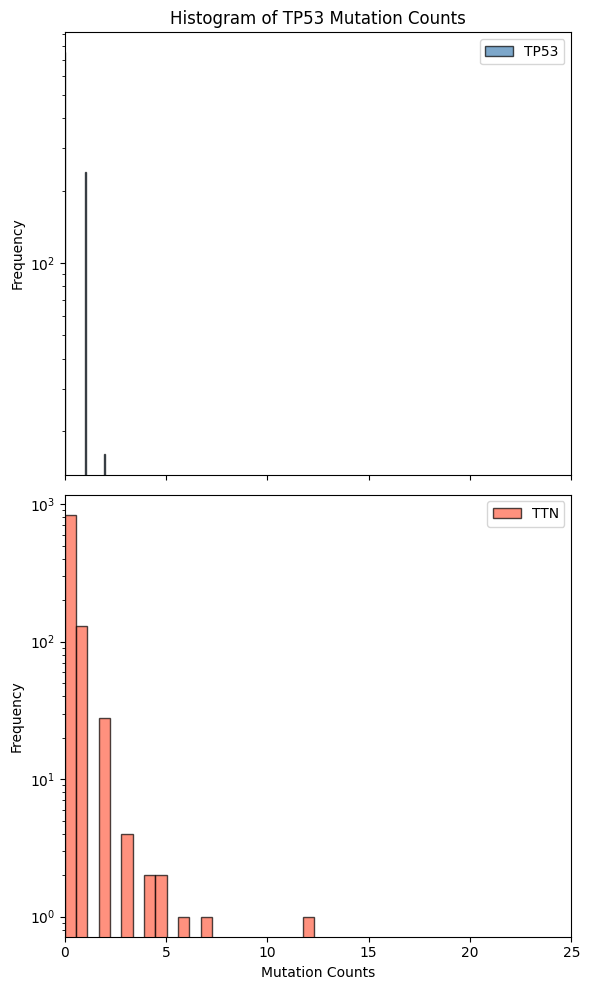

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the counts
tp53_counts = cnt_mtx_df['TP53_M'] + cnt_mtx_df['TP53_N']
ttn_counts = cnt_mtx_df['TTN_M']

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(6, 10), sharex=True)

# Plot the histograms
axes[0].hist(tp53_counts, bins=50, color='steelblue', alpha=0.7, edgecolor='black', label='TP53')
axes[1].hist(ttn_counts, bins=50, color='tomato', alpha=0.7, edgecolor='black', label='TTN')

# Set labels and limits
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of TP53 Mutation Counts')
axes[1].set_xlabel('Mutation Counts')
axes[1].set_ylabel('Frequency')
axes[0].legend()
axes[1].legend()

# Set x-axis limits for both subplots
axes[0].set_xlim(0, 25)
axes[1].set_xlim(0, 25)

axes[0].set_yscale('log')
axes[1].set_yscale('log')

# Adjust layout and show plot
plt.tight_layout()

# save as svg
plt.savefig('hist.svg')



In [62]:
gene_to_exp_bm_counts = {}
for key, pmfs in bmr_pmfs_dict.items():
    exp_value = sum([i * x for i, x in enumerate(pmfs)])
    gene_to_exp_bm_counts[key] = exp_value

In [81]:
sorted(gene_to_exp_bm_counts.items(), key=lambda x: x[1])

[('HBA1_N', 1.1538531435175451e-05),
 ('HBA2_N', 1.1538531435175451e-05),
 ('TPRXL_N', 1.1695866300987157e-05),
 ('C1QL4_N', 1.3860781299532584e-05),
 ('CDC42EP5_N', 1.3907706598878415e-05),
 ('CTU1_N', 1.417807747831658e-05),
 ('KLF16_N', 1.4316203483588333e-05),
 ('FOXD2_N', 1.4397793011231212e-05),
 ('C1QL1_N', 1.519756926672735e-05),
 ('GPR27_N', 1.536822047805097e-05),
 ('NANOS1_N', 1.5396203979104088e-05),
 ('FOXE3_N', 1.5503877509086594e-05),
 ('FMR1-AS1_N', 1.5763130472308675e-05),
 ('SLC16A8_N', 1.6326093935849112e-05),
 ('MUC21_N', 1.639677334077234e-05),
 ('PRR21_N', 1.6419166329002756e-05),
 ('HIST1H1E_N', 1.6533221612986336e-05),
 ('UNCX_N', 1.6546703426927343e-05),
 ('JUND_N', 1.662007332209858e-05),
 ('S1PR5_N', 1.6688862640227957e-05),
 ('OLIG2_N', 1.7060903701477877e-05),
 ('LOC100128750_N', 1.7109790493623286e-05),
 ('INSM1_N', 1.7193312144962536e-05),
 ('LOC389332_N', 1.7266272368190407e-05),
 ('FOXE1_N', 1.736428617231381e-05),
 ('NRGN_N', 1.7455199044167065e-05),
 

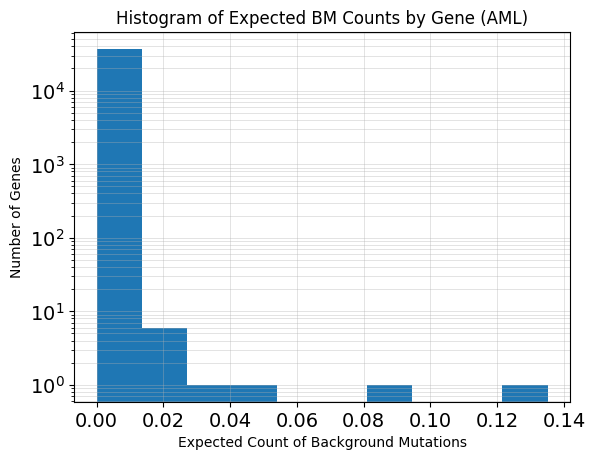

In [80]:
plt.hist(gene_to_exp_bm_counts.values(), log=True)

# Set title and labels
plt.title('Histogram of Expected BM Counts by Gene (AML)')
plt.xlabel('Expected Count of Background Mutations')
plt.ylabel('Number of Genes')

# Adjust tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Set grid
plt.grid(True, which='both', linestyle='-', linewidth=0.5, alpha=0.5)

# Save the plot to a file
plt.savefig('gene_to_exp_bm_counts_hist.png')


(array([3.6868e+04, 6.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.15385314e-05, 1.35180684e-02, 2.70245983e-02, 4.05311282e-02,
        5.40376581e-02, 6.75441880e-02, 8.10507179e-02, 9.45572478e-02,
        1.08063778e-01, 1.21570308e-01, 1.35076837e-01]),
 <BarContainer object of 10 artists>)

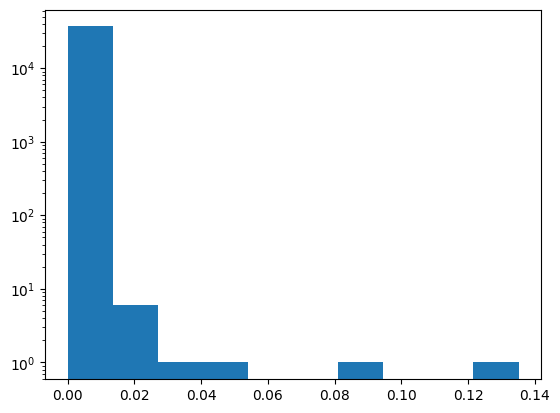

In [12]:
plt.hist(gene_to_exp_bm_counts.values(), log=True)

In [25]:
# SHARED PARAMETERS
tau_11 = 0 # no co-occurring drivers at all
nruns = 100
nsamples = 1_000

driver_genes = ["DNMT3A_M", "IDH2_M", "FLT3_M", "IDH1_M", "TP53_M", "NRAS_M", "RUNX1_M", "KRAS_M", "U2AF1_M", "PTPN11_M"]
# me_pairs = [("DNMT3A_M", "IDH2_M"), ("FLT3_M", "IDH1_M"), ("TP53_M", "NRAS_M"), ("RUNX1_M", "KRAS_M"), ("U2AF1_M", "PTPN11_M")]
me_pairs = [(gene, "LRP1B_M") for gene in driver_genes]
me_taus =  [0.1] * len(me_pairs)
pair_to_pvals = {}

for i, pair in enumerate(me_pairs):
    tau_10, tau_01 = me_taus[i], me_taus[i]
    pair = me_pairs[i]
    gene_a, gene_b = pair
    gene_a_bmr_pmfs, gene_b_bmr_pmfs = np.array(bmr_pmfs_dict[gene_a]), np.array(bmr_pmfs_dict[gene_b])
    gene_a_bmr_pmfs, gene_b_bmr_pmfs = gene_a_bmr_pmfs / sum(gene_a_bmr_pmfs), gene_b_bmr_pmfs / sum(gene_b_bmr_pmfs)
    fisher_pvals, dialect_results = [], []
    for run in tqdm(range(nruns)):
        gene_a_passenger_mutations = np.random.choice(len(gene_a_bmr_pmfs), nsamples, p=gene_a_bmr_pmfs)
        gene_b_passenger_mutations = np.random.choice(len(gene_b_bmr_pmfs), nsamples, p=gene_b_bmr_pmfs)
        gene_a_driver_mutations, gene_b_driver_mutations = generate_pairwise_driver_mutations(
            nsamples, tau_10, tau_01, tau_11
        )
        gene_a_somatic_mutations = (gene_a_passenger_mutations + gene_a_driver_mutations).astype(int)
        gene_b_somatic_mutations = (gene_b_passenger_mutations + gene_b_driver_mutations).astype(int)
        gene_a_binarized_mutations = np.array([1 if x > 0 else 0 for x in gene_a_somatic_mutations])
        gene_b_binarized_mutations = np.array([1 if x > 0 else 0 for x in gene_b_somatic_mutations])
        contingency_table = confusion_matrix(gene_a_binarized_mutations, gene_b_binarized_mutations, labels=[1,0])
        fishers_pval = stats.fisher_exact(contingency_table, alternative='less')[1]
        dialect_result = run_single_pair_dialect(gene_a_bmr_pmfs, gene_b_bmr_pmfs, gene_a_somatic_mutations, gene_b_somatic_mutations)
        fisher_pvals.append(fishers_pval)
        dialect_results.append(dialect_result[-1])
    pair_to_pvals[pair] = (fisher_pvals, dialect_results)

100%|██████████| 100/100 [00:01<00:00, 61.00it/s]


In [26]:
# get all fisher pvals from the pair_to_pvals dict and concatenate them into one list
all_fisher_pvals = []
all_dialect_pvals = []
for fisher_result, dialect_result in pair_to_pvals.values():
    all_fisher_pvals.extend(fisher_result)
    all_dialect_pvals.extend(dialect_result)

100%|██████████| 1000/1000 [00:00<00:00, 5560.08it/s]


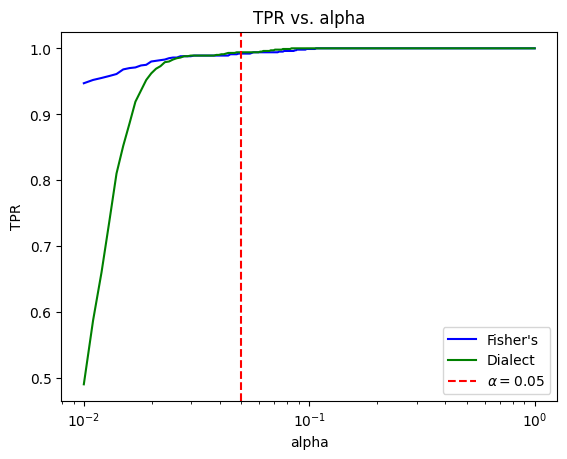

In [27]:
# create a plot of TPR vs. alpha threshold for different values of alpha
fisher_tprs = []
dialect_tprs = []
alphas = np.linspace(1e-2, 1, 1000) 
for alpha in tqdm(alphas):
    fisher_tpr = sum(np.array(all_fisher_pvals) < alpha) / len(all_fisher_pvals)
    dialect_tpr = sum(np.array(all_dialect_pvals) < alpha) / len(all_dialect_pvals)
    fisher_tprs.append(fisher_tpr)
    dialect_tprs.append(dialect_tpr)

plt.plot(alphas, fisher_tprs, color='blue', label='Fisher\'s')
plt.plot(alphas, dialect_tprs, color='green', label='Dialect')

plt.xlabel('alpha')
plt.ylabel('TPR')
plt.title('TPR vs. alpha')
plt.axvline(x=0.05, color='red', linestyle='--', label=r'$\alpha = 0.05$')
plt.legend()

# plt.ylim(0, 1)
plt.xscale('log')

In [41]:
lowest_bmr_gene = 'HBA1_N'
highest_bmr_gene = 'TTN_M'
num_pairs = 10
me_pairs = []
for i in range(num_pairs):
    high_bmr_driver = f"HIGH_BMR_DRIVER_{i}"
    low_bmr_driver = f"LOW_BMR_DRIVER_{i}"
    bmr_pmfs_dict[high_bmr_driver] = bmr_pmfs_dict[highest_bmr_gene]
    bmr_pmfs_dict[low_bmr_driver] = bmr_pmfs_dict[lowest_bmr_gene]

    me_pairs.append((high_bmr_driver, low_bmr_driver))

passengers = []
num_passengers = 80
for i in range(num_passengers):
    high_bmr_passenger = f"HIGH_BMR_PASSENGER_{i}"
    # low_bmr_passenger = f"LOW_BMR_PASSENGER_{i}"
    bmr_pmfs_dict[high_bmr_passenger] = bmr_pmfs_dict[highest_bmr_gene]
    # bmr_pmfs_dict[low_bmr_passenger] = bmr_pmfs_dict[lowest_bmr_gene]
    passengers.append(high_bmr_passenger)
    # passengers.append(low_bmr_passenger)

me_taus = np.random.choice(np.linspace(0.1, 0.2, 10), num_pairs, replace=True)

In [50]:
# SMALL MATRIX POSITIVE CASES ONLY
tau_11 = 0  # no co-occurring drivers at all
nruns = 10
nsamples = 1_000
pair_to_pvals = {}

def generate_somatic_mutations(nsamples, gene_a_bmr_pmfs, gene_b_bmr_pmfs, tau_10, tau_01, tau_11):
    gene_a_passenger_mutations = np.random.choice(len(gene_a_bmr_pmfs), nsamples, p=gene_a_bmr_pmfs)
    gene_b_passenger_mutations = np.random.choice(len(gene_b_bmr_pmfs), nsamples, p=gene_b_bmr_pmfs)
    gene_a_driver_mutations, gene_b_driver_mutations = generate_pairwise_driver_mutations(
        nsamples, tau_10, tau_01, tau_11
    )
    gene_a_somatic_mutations = (gene_a_passenger_mutations + gene_a_driver_mutations).astype(int)
    gene_b_somatic_mutations = (gene_b_passenger_mutations + gene_b_driver_mutations).astype(int)
    return gene_a_somatic_mutations, gene_b_somatic_mutations


all_positive_fisher_pvals = []
all_negative_fisher_pvals = []
all_positive_dialect_pvals = []
all_negative_dialect_pvals = []
for _ in tqdm(range(nruns)):
    cnt_mtx = []
    for i, pair in enumerate(me_pairs):
        tau_10, tau_01 = me_taus[i], me_taus[i]
        gene_a, gene_b = pair
        gene_a_bmr_pmfs, gene_b_bmr_pmfs = np.array(bmr_pmfs_dict[gene_a]), np.array(bmr_pmfs_dict[gene_b])
        gene_a_bmr_pmfs, gene_b_bmr_pmfs = gene_a_bmr_pmfs / sum(gene_a_bmr_pmfs), gene_b_bmr_pmfs / sum(gene_b_bmr_pmfs)
        gene_a_somatic, gene_b_somatic = generate_somatic_mutations(nsamples, gene_a_bmr_pmfs, gene_b_bmr_pmfs, tau_10, tau_01, tau_11)
        cnt_mtx.append(gene_a_somatic)
        cnt_mtx.append(gene_b_somatic)
    for passenger in passengers:
        gene_bmr_pmf = np.array(bmr_pmfs_dict[passenger])
        gene_bmr_pmf = gene_bmr_pmf / sum(gene_bmr_pmf)
        gene_somatic = np.random.choice(len(gene_bmr_pmf), nsamples, p=gene_bmr_pmf)
        cnt_mtx.append(gene_somatic)
    
    cnt_mtx = np.array(cnt_mtx).T
    single_genes = [gene for pair in me_pairs for gene in pair] + passengers
    cnt_mtx_df = pd.DataFrame(cnt_mtx, columns = single_genes)

    gene_pairs = list(combinations(single_genes, 2))
    for gene_a, gene_b in gene_pairs:
        gene_a_bmr_pmfs, gene_b_bmr_pmfs = np.array(bmr_pmfs_dict[gene_a]), np.array(bmr_pmfs_dict[gene_b])
        gene_a_bmr_pmfs, gene_b_bmr_pmfs = gene_a_bmr_pmfs / sum(gene_a_bmr_pmfs), gene_b_bmr_pmfs / sum(gene_b_bmr_pmfs)
        gene_a_somatic, gene_b_somatic = cnt_mtx_df[gene_a].values, cnt_mtx_df[gene_b].values
        gene_a_binary, gene_b_binary = np.where(gene_a_somatic > 0, 1, 0), np.where(gene_b_somatic > 0, 1, 0)
        contingency_table = confusion_matrix(gene_a_binary, gene_b_binary, labels=[1,0])
        fishers_pval = stats.fisher_exact(contingency_table, alternative='less')[1]
        dialect_pval = run_single_pair_dialect(gene_a_bmr_pmfs, gene_b_bmr_pmfs, gene_a_somatic, gene_b_somatic)[-1]

        if (gene_a, gene_b) in me_pairs:
            all_positive_fisher_pvals.append(fishers_pval)
            all_positive_dialect_pvals.append(dialect_pval)
        else:
            all_negative_fisher_pvals.append(fishers_pval)
            all_negative_dialect_pvals.append(dialect_pval)

100%|██████████| 10/10 [28:02<00:00, 168.21s/it]


In [51]:
# DISCOVER VALS
all_positive_discover_pvals = pd.read_csv('positive_discover_pvals.csv', header=None)[0].values.tolist()
all_negative_discover_pvals = pd.read_csv('negative_discover_pvals.csv', header=None)[0].values.tolist()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 13720.42it/s]


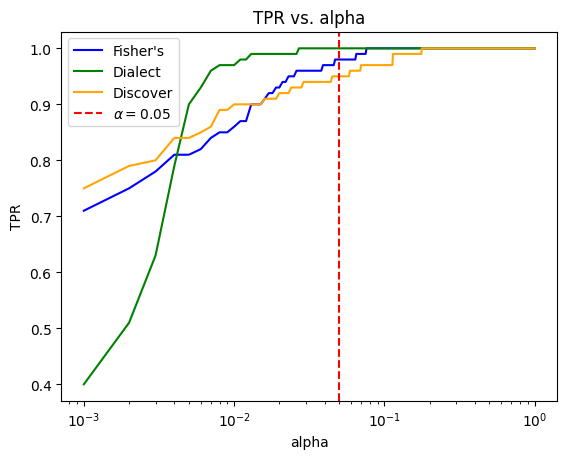

In [52]:
# create a plot of TPR vs. alpha threshold for different values of alpha
fisher_tprs = []
dialect_tprs = []
discover_tprs = []
alphas = np.linspace(1e-3, 1, 1000) 
for alpha in tqdm(alphas):
    fisher_tpr = sum(np.array(all_positive_fisher_pvals) < alpha) / len(all_positive_fisher_pvals)
    dialect_tpr = sum(np.array(all_positive_dialect_pvals) < alpha) / len(all_positive_dialect_pvals)
    discover_tpr = sum(np.array(all_positive_discover_pvals) < alpha) / len(all_positive_discover_pvals)
    fisher_tprs.append(fisher_tpr)
    dialect_tprs.append(dialect_tpr)
    discover_tprs.append(discover_tpr)
plt.plot(alphas, fisher_tprs, color='blue', label='Fisher\'s')
plt.plot(alphas, dialect_tprs, color='green', label='Dialect')
plt.plot(alphas, discover_tprs, color='orange', label='Discover')

plt.xlabel('alpha')
plt.ylabel('TPR')
plt.title('TPR vs. alpha')
plt.axvline(x=0.05, color='red', linestyle='--', label=r'$\alpha = 0.05$')
plt.legend()

# plt.ylim(0, 1)
plt.xscale('log')

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:07<00:00, 137.80it/s]


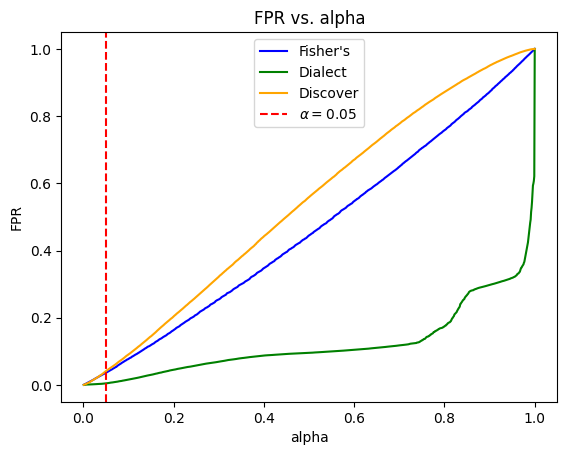

In [53]:
# create a plot of TPR vs. alpha threshold for different values of alpha
fisher_fprs = []
dialect_fprs = []
discover_fprs = []
alphas = np.linspace(1e-3, 1, 1000) 
for alpha in tqdm(alphas):
    fisher_fpr = sum(np.array(all_negative_fisher_pvals) < alpha) / len(all_negative_fisher_pvals)
    dialect_fpr = np.sum((all_negative_dialect_pvals < alpha)) / len(all_negative_dialect_pvals)
    discover_fpr = np.sum((all_negative_discover_pvals < alpha)) / len(all_negative_discover_pvals)
    fisher_fprs.append(fisher_fpr)
    dialect_fprs.append(dialect_fpr)
    discover_fprs.append(discover_fpr)

plt.plot(alphas, fisher_fprs, color='blue', label='Fisher\'s')
plt.plot(alphas, dialect_fprs, color='green', label='Dialect')
plt.plot(alphas, discover_fprs, color='orange', label='Discover')
plt.axvline(x=0.05, color='red', linestyle='--', label=r'$\alpha = 0.05$')

plt.xlabel('alpha')
plt.ylabel('FPR')
plt.title('FPR vs. alpha')
plt.legend()
# plt.ylim(0, 1)
# plt.xscale('log')

In [54]:
# compute recall = true positive rate
# compute precision = tp / (tp + fp)
fisher_recalls, dialect_recalls = [], []
fisher_precisions, dialect_precisions = [], []
alphas = np.linspace(1e-3, 1, 1000) 
discover_precisions, discover_recalls = [], []
fisher_f1s, dialect_f1s, discover_f1s = [], [], []
for alpha in tqdm(alphas):
    fisher_recalls.append(sum(np.array(all_positive_fisher_pvals) < alpha) / len(all_positive_fisher_pvals))
    dialect_recalls.append(sum(np.array(all_positive_dialect_pvals) < alpha) / len(all_positive_dialect_pvals))
    discover_recalls.append(sum(np.array(all_positive_discover_pvals) < alpha) / len(all_positive_discover_pvals))
    fisher_tp, fisher_fp = sum(np.array(all_positive_fisher_pvals) < alpha), sum(np.array(all_negative_fisher_pvals) < alpha)
    dialect_tp, dialect_fp = sum(np.array(all_positive_dialect_pvals) < alpha), sum(np.array(all_negative_dialect_pvals) < alpha)
    discover_tp, discover_fp = sum(np.array(all_positive_discover_pvals) < alpha), sum(np.array(all_negative_discover_pvals) < alpha)
    fisher_precisions.append(fisher_tp / (fisher_tp + fisher_fp))
    dialect_precisions.append(dialect_tp / (dialect_tp + dialect_fp))
    discover_precisions.append(discover_tp / (discover_tp + discover_fp))
    fisher_f1s.append(2 * fisher_precisions[-1] * fisher_recalls[-1] / (fisher_precisions[-1] + fisher_recalls[-1]))
    dialect_f1s.append(2 * dialect_precisions[-1] * dialect_recalls[-1] / (dialect_precisions[-1] + dialect_recalls[-1]))
    discover_f1s.append(2 * discover_precisions[-1] * discover_recalls[-1] / (discover_precisions[-1] + discover_recalls[-1]))

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:13<00:00, 75.59it/s]


In [55]:
from sklearn.metrics import auc

fisher_auc = auc(fisher_recalls, fisher_precisions)
dialect_auc = auc(dialect_recalls, dialect_precisions)
discover_auc = auc(discover_recalls, discover_precisions)

print(f"Fisher's Precision-Recall AUC: {fisher_auc:.2f}")
print(f"Dialect Precision-Recall AUC: {dialect_auc:.2f}")
print(f"Discover Precision-Recall AUC: {discover_auc:.2f}")

Fisher's Precision-Recall AUC: 0.08
Dialect Precision-Recall AUC: 0.42
Discover Precision-Recall AUC: 0.08


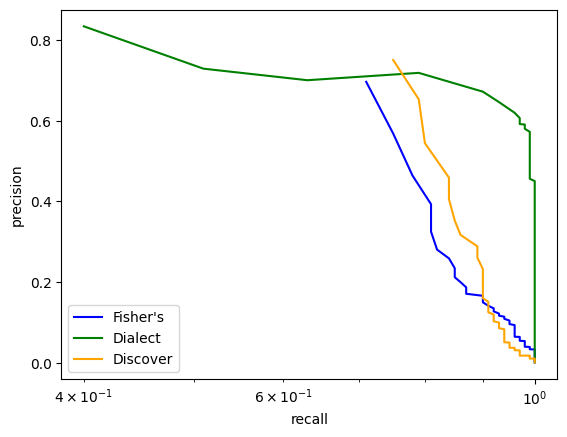

In [56]:
# plt.plot(alphas, fisher_precisions, label='precision')
# plt.plot(alphas, fisher_recalls, label='recall')
# plt.plot(alphas, fisher_f1s, label='F1')
plt.plot(fisher_recalls, fisher_precisions, label='Fisher\'s', color='blue')
plt.plot(dialect_recalls, dialect_precisions, label='Dialect', color='green')
plt.plot(discover_recalls, discover_precisions, label='Discover', color='orange')
plt.xscale('log')
plt.ylabel('precision')
plt.xlabel('recall')
plt.legend()

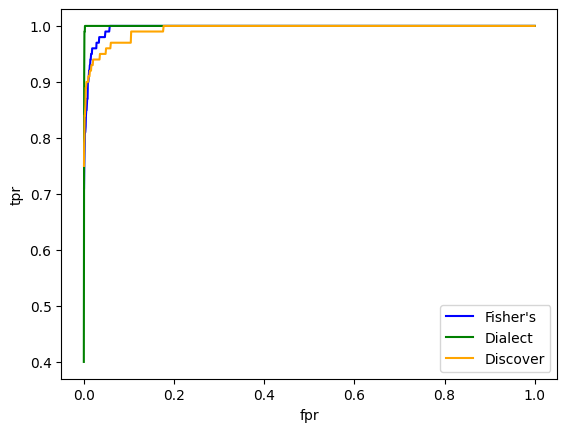

In [57]:
plt.plot(fisher_fprs, fisher_tprs, label='Fisher\'s', color='blue')
plt.plot(dialect_fprs, dialect_tprs, label='Dialect', color='green')
plt.plot(discover_fprs, discover_tprs, label='Discover', color='orange')
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.legend()

In [60]:
# NEGATIVE CASE

gene_a = 'DNMT3A_M'
gene_b = 'TTN_M'

gene_a_bmr_pmfs = np.array(bmr_pmfs_dict[gene_a])
gene_a_bmr_pmfs = gene_a_bmr_pmfs / sum(gene_a_bmr_pmfs)
gene_b_bmr_pmfs = np.array(bmr_pmfs_dict[gene_b])
gene_b_bmr_pmfs = gene_b_bmr_pmfs / sum(gene_b_bmr_pmfs)
nruns = 1000
negative_fisher_pvals = []
negative_dialect_me_pvals = []
for run in tqdm(range(nruns)):
    gene_a_passenger_mutations = np.random.choice(len(gene_a_bmr_pmfs), nsamples, p=gene_a_bmr_pmfs)
    gene_b_passenger_mutations = np.random.choice(len(gene_b_bmr_pmfs), nsamples, p=gene_b_bmr_pmfs)
    tau_10, tau_01, tau_11 = 0.05, 0, 0
    gene_a_driver_mutations, gene_b_driver_mutations = generate_pairwise_driver_mutations(nsamples, tau_10, tau_01, tau_11)
    gene_a_somatic_mutations = (gene_a_passenger_mutations + gene_a_driver_mutations).astype(int)
    gene_b_somatic_mutations = (gene_b_passenger_mutations + gene_b_driver_mutations).astype(int)
    gene_a_binarized_mutations = np.array([1 if x > 0 else 0 for x in gene_a_somatic_mutations])
    gene_b_binarized_mutations = np.array([1 if x > 0 else 0 for x in gene_b_somatic_mutations])
    contingency_table = confusion_matrix(gene_a_binarized_mutations, gene_b_binarized_mutations, labels=[1,0])
    fishers_pval = stats.fisher_exact(contingency_table, alternative='less')[1]
    dialect_result = run_single_pair_dialect(gene_a_bmr_pmfs, gene_b_bmr_pmfs, gene_a_somatic_mutations, gene_b_somatic_mutations)
    negative_fisher_pvals.append(fishers_pval)
    negative_dialect_me_pvals.append(dialect_result[-1])


100%|██████████| 1000/1000 [00:29<00:00, 34.10it/s]


100%|██████████| 1000/1000 [00:00<00:00, 6700.97it/s]


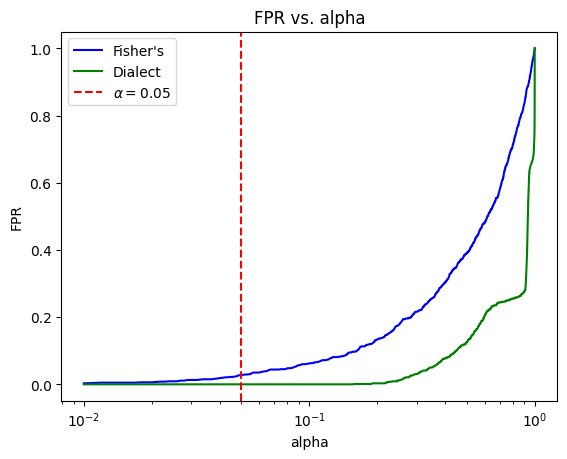

In [61]:
# create a plot of TPR vs. alpha threshold for different values of alpha
fisher_fprs = []
dialect_fprs = []
alphas = np.linspace(1e-2, 1, 1000) 
for alpha in tqdm(alphas):
    fisher_fpr = sum(np.array(negative_fisher_pvals) < alpha) / len(negative_fisher_pvals)
    dialect_fpr = np.sum((negative_dialect_me_pvals < alpha) & (negative_dialect_me_pvals < alpha)) / len(negative_dialect_me_pvals)
    fisher_fprs.append(fisher_fpr)
    dialect_fprs.append(dialect_fpr)

plt.plot(alphas, fisher_fprs, color='blue', label='Fisher\'s')
plt.plot(alphas, dialect_fprs, color='green', label='Dialect')
plt.axvline(x=0.05, color='red', linestyle='--', label=r'$\alpha = 0.05$')

plt.xlabel('alpha')
plt.ylabel('FPR')
plt.title('FPR vs. alpha')
plt.legend()
# plt.ylim(0, 1)
plt.xscale('log')

In [93]:
nsamples = 1000
passenger_cnts_dict = {}
for gene in ['TP53_N', 'CDH1_N'] + list(top_genes[:-2]): # manually include 2 more drivers
    bmr_pmfs = bmr_pmfs_dict[gene]
    bmr_pmfs = np.array(bmr_pmfs)
    bmr_pmfs = bmr_pmfs / sum(bmr_pmfs)
    passenger_mutations = np.random.choice(len(bmr_pmfs), nsamples, p=bmr_pmfs)
    passenger_cnts_dict[gene] = passenger_mutations
sim_cnt_mtx_df = pd.DataFrame(passenger_cnts_dict)

In [64]:
me_pairs = [['TP53_N', 'CDH1_N'], ['TP53_M', 'PIK3CA_M']]
for gene_a, gene_b in me_pairs:
    gene_a_mutations, gene_b_mutations = generate_pairwise_driver_mutations(nsamples, 0.025, 0.025, 0)
    sim_cnt_mtx_df[gene_a] += gene_a_mutations
    sim_cnt_mtx_df[gene_b] += gene_b_mutations

In [65]:
gene_a = 'TP53_N'
gene_b = 'CDH1_N'


gene_a_binarized_mutations = np.array([1 if x > 0 else 0 for x in sim_cnt_mtx_df[gene_a]])
gene_b_binarized_mutations = np.array([1 if x > 0 else 0 for x in sim_cnt_mtx_df[gene_b]])

In [68]:
from sklearn.metrics import confusion_matrix
from scipy.stats import fisher_exact
contingency_table = confusion_matrix(gene_a_binarized_mutations, gene_b_binarized_mutations, labels=[1, 0])
oddsratio, pvalue = fisher_exact(contingency_table, alternative='less')
oddsratio, pvalue

(np.float64(0.0), np.float64(0.35584420461273447))

In [80]:
alphas = np.linspace(0, 1, 101)
gene_a, gene_b = 'TP53_N', 'CDH1_N'
gene_a_bmr_pmfs = np.array(bmr_pmfs_dict[gene_a])
gene_a_bmr_pmfs = gene_a_bmr_pmfs / sum(gene_a_bmr_pmfs)
gene_b_bmr_pmfs = np.array(bmr_pmfs_dict[gene_b])
gene_b_bmr_pmfs = gene_b_bmr_pmfs / sum(gene_b_bmr_pmfs)

me_tau = 0.025
nsamples = 1000
niter = 1000
sig_cnt = np.zeros_like(alphas)
for _ in range(niter):
    gene_a_passenger_mutations = np.random.choice(len(gene_a_bmr_pmfs), nsamples, p=gene_a_bmr_pmfs)
    gene_b_passenger_mutations = np.random.choice(len(gene_b_bmr_pmfs), nsamples, p=gene_b_bmr_pmfs)
    gene_a_driver_mutations, gene_b_driver_mutations = generate_pairwise_driver_mutations(nsamples, me_tau, me_tau, 0)
    gene_a_mutations = gene_a_passenger_mutations + gene_a_driver_mutations
    gene_b_mutations = gene_a_passenger_mutations + gene_b_driver_mutations
    gene_a_binarized_mutations = np.array([1 if x > 0 else 0 for x in gene_a_mutations])
    gene_b_binarized_mutations = np.array([1 if x > 0 else 0 for x in gene_b_mutations])
    contingency_table = confusion_matrix(gene_a_binarized_mutations, gene_b_binarized_mutations, labels=[1, 0])
    _, pvalue = fisher_exact(contingency_table, alternative='less')
    sig_cnt += (pvalue > alphas).astype(int) # adding false positives

Text(0, 0.5, 'y')

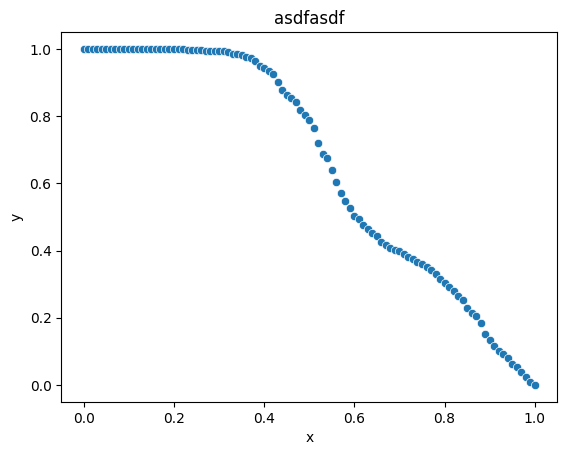

In [92]:
import seaborn as sns 

ax = sns.scatterplot(x=alphas, y=sig_cnt / niter)
ax.set_title('asdfasdf')
ax.set_xlabel('x')
ax.set_ylabel('y')

# TODO NEXT: WHY DOESNT THIS PLOT MATCH DISCOVER PLOTS WHERE THE DIAGONAL IS BOTTOM LEFT TO TOP RIGHT
# SHOULD THE FALSE POSITIVE RATE INCREASE AS YOU INCREASE ALPHA WHEN YOU ONLY TAKE A LOOK AT A SINGLE ME PAIR? 
# NO SINCE YOU CAN NEVER CLASSIFY AS ME BUT BE WRONG... IT IS ONLY ME... SO THAT MEANS DISCOVER HAS NEGATIVE
# EXAMPLES.... HOW MANY RELATIVE TO THE POSITIVE EXAMPLE?? SHOULD I INCLUDE A SINGLE POSITIVE EXAMPLE AND 
# A SINGLE NEGATIVE EXAMPLE AT FIRST? IT SHOULDNT MATTER..... AS LONG AS THERE IS SOME BALANCE


In [ ]:
# run dialect and create threshold plots
# run discover and create threshold plots
# run other methods and create threshold plots

### CODE-015: Visualization of BMRs Across Cancer Subtypes

In [1]:
import os
import numpy as np
import pandas as pd

RESULTS_DIR = '/Users/work/workspace/research/dialect/results/tcga_pancan_atlas_2018'
BMR_BASE_FN = os.path.join(RESULTS_DIR, '{}/{}_cbase_bmr_pmfs.csv')

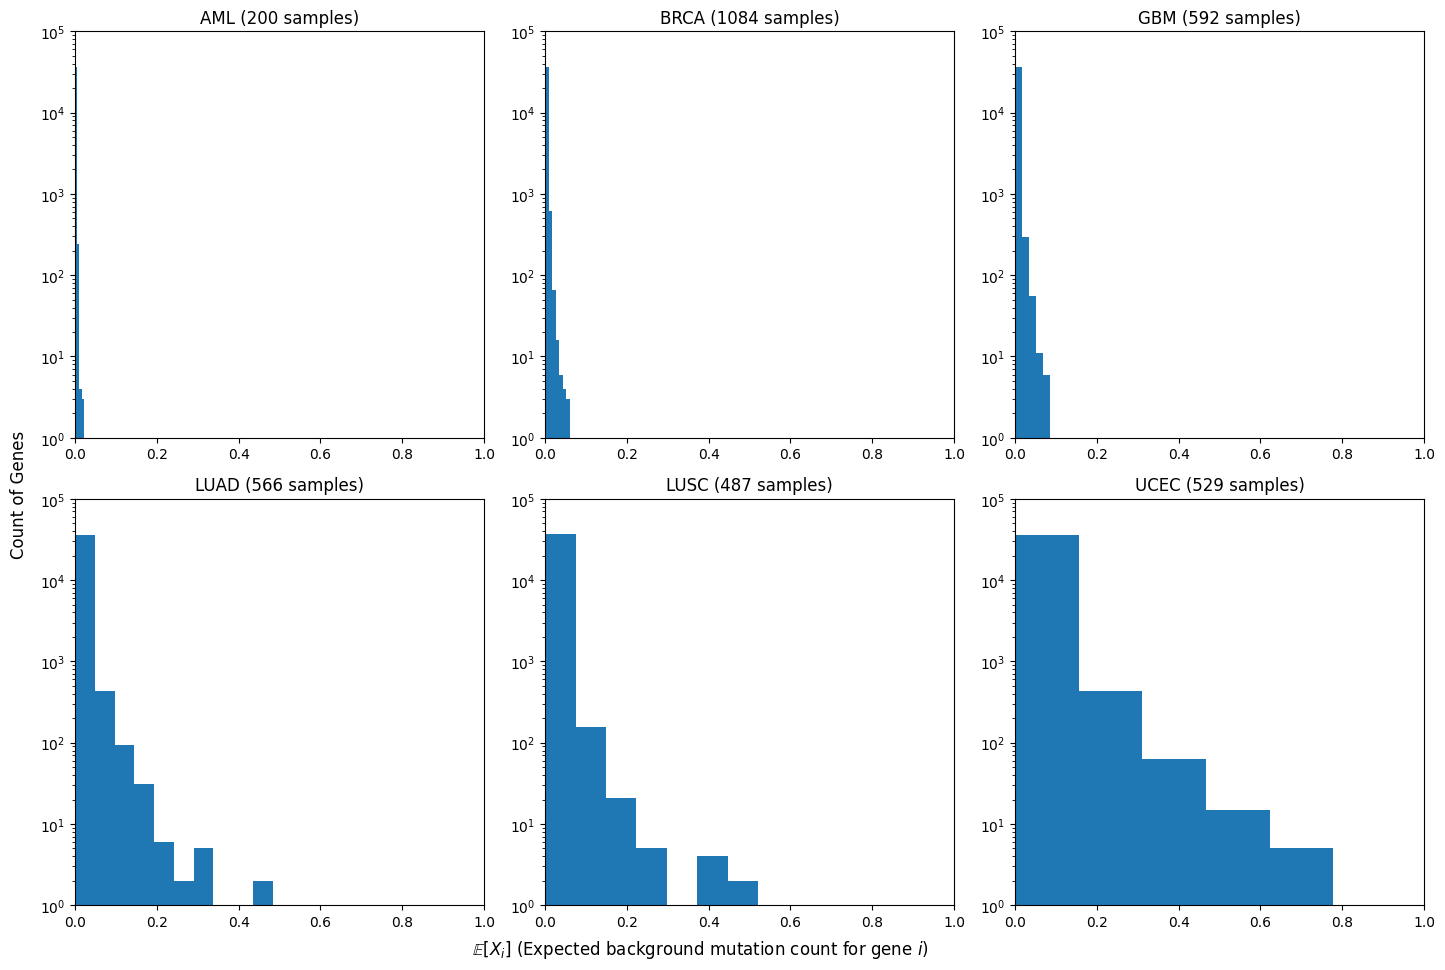

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_expected_background_counts(bmr_fn):
    df = pd.read_csv(bmr_fn, index_col=0, header=0)
    df.fillna(0, inplace=True)
    df.columns = df.columns.astype(int)
    expected_background_gene_counts = df.apply(lambda row: np.sum(row * row.index), axis=1)
    return expected_background_gene_counts

# Define the list of cancer subtypes
cancer_subtypes = ['AML', 'BRCA', 'GBM', 'LUAD', 'LUSC', 'UCEC']
num_samples = [200, 1084, 592, 566, 487, 529]

# Set up a 2x3 subplot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, subtype in enumerate(cancer_subtypes):
    bmr_fn = BMR_BASE_FN.format(subtype, subtype)
    counts = compute_expected_background_counts(bmr_fn)
    
    # Plot histogram in the respective subplot
    axes[i].hist(counts, bins=25, log=True)
    axes[i].set_ylim(1, 10e4)
    axes[i].set_xlim(0, 1)
    axes[i].set_title('{} ({} samples)'.format(subtype, num_samples[i]))

# Add common x-axis and y-axis labels
fig.text(0.5, 0.04, r'$\mathbb{E}[X_i]$ (Expected background mutation count for gene $i$)', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Count of Genes', va='center', rotation='vertical', fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()

### CODE-010: DIALECT MILD Results EDA

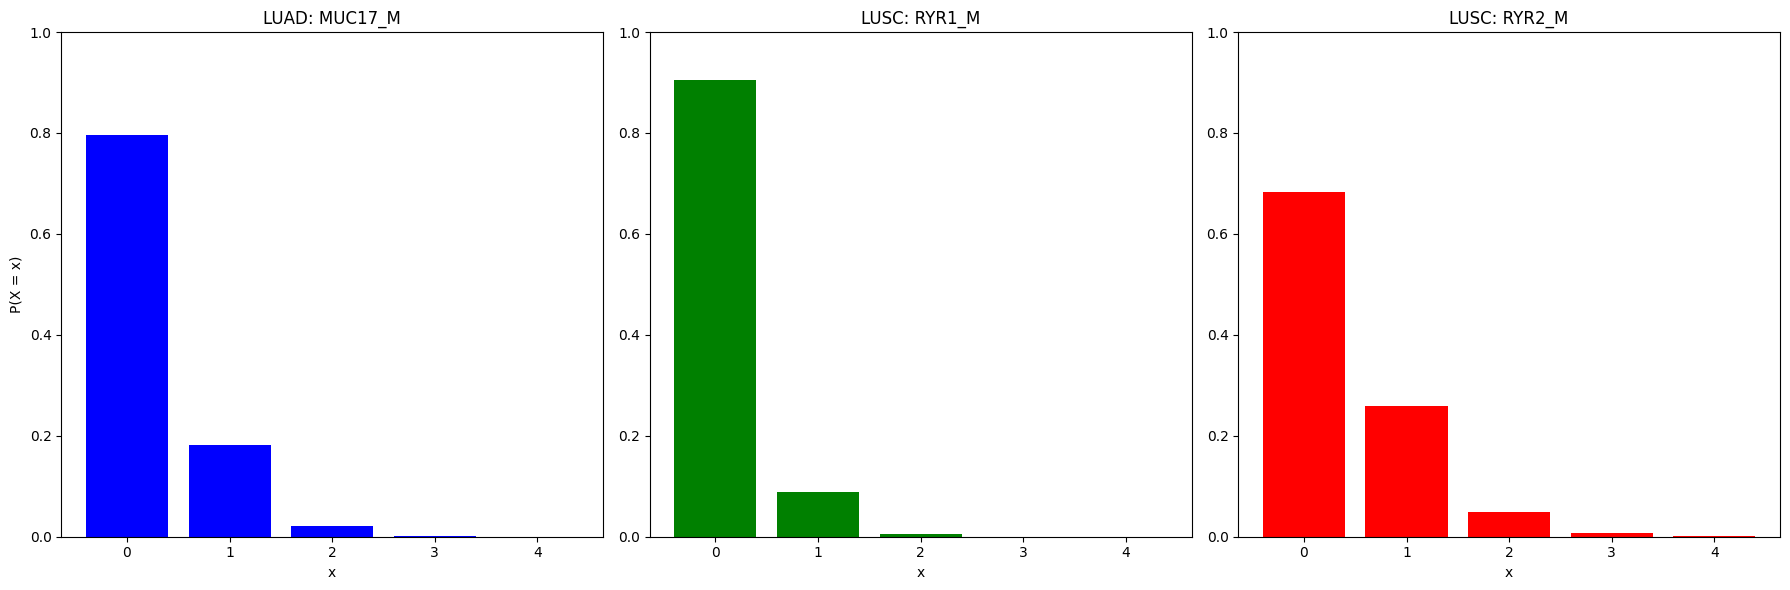

In [20]:
# plot of bmr distributions for select suspicious genes that pop up in pairwise results for 
# LUAD and LUSC

import matplotlib.pyplot as plt

# Data for the three genes
MUC17_M = [0.795291, 0.181705, 0.021210, 0.001686, 0.000103]
RYR1_M = [0.905903, 0.089312, 0.004613, 0.000166, 0.000005]
RYR2_M = [0.683866, 0.259052, 0.049874, 0.006505, 0.000646]

# X-axis labels
x_labels = ['0', '1', '2', '3', '4']

# Creating the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for MUC17_M with LUAD in the title
axes[0].bar(x_labels, MUC17_M, color='blue')
axes[0].set_title('LUAD: MUC17_M')
axes[0].set_xlabel('x')
axes[0].set_ylabel('P(X = x)')
axes[0].set_ylim(0,1)

# Plot for RYR1_M with LUSC in the title
axes[1].bar(x_labels, RYR1_M, color='green')
axes[1].set_title('LUSC: RYR1_M')
axes[1].set_xlabel('x')
axes[1].set_ylim(0,1)

# Plot for RYR2_M with LUSC in the title
axes[2].bar(x_labels, RYR2_M, color='red')
axes[2].set_title('LUSC: RYR2_M')
axes[2].set_xlabel('x')
axes[2].set_ylim(0,1)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

Text(0.04, 0.5, 'Count of Genes')

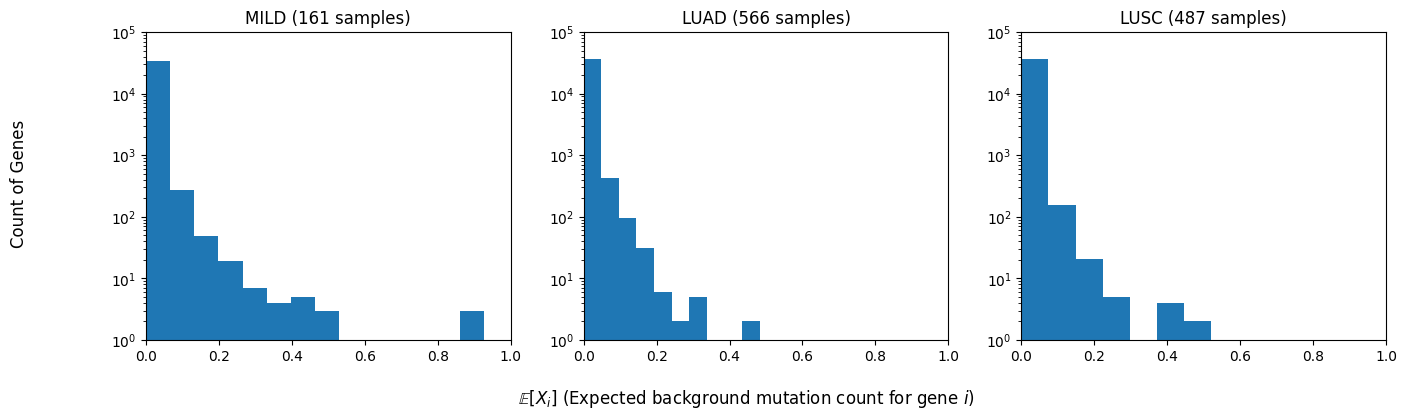

In [28]:
# MILD vs. LUAD vs. LUSC BMR Distributions

BASE_RES_DIR = '/Users/work/workspace/research/dialect/results/'
TCGA_RES_DIR = os.path.join(BASE_RES_DIR, 'tcga_pancan_atlas_2018')
GDAN_RES_DIR = os.path.join(BASE_RES_DIR, 'gdan_2024')

mild_bmr_fn = os.path.join(GDAN_RES_DIR, 'MILD/MILD_cbase_bmr_pmfs.csv')
luad_bmr_fn = os.path.join(TCGA_RES_DIR, 'LUAD/LUAD_cbase_bmr_pmfs.csv')
lusc_bmr_fn = os.path.join(TCGA_RES_DIR, 'LUSC/LUSC_cbase_bmr_pmfs.csv')
BMR_BASE_FN = os.path.join(RESULTS_DIR, '{}/{}_cbase_bmr_pmfs.csv')

subtype_to_samples = {'MILD': 161, 'LUAD': 566, 'LUSC': 487}
subtypes = list(subtype_to_samples.keys())
num_samples = list(subtype_to_samples.values())

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes = axes.flatten()

for i, bmr_fn in enumerate([mild_bmr_fn, luad_bmr_fn, lusc_bmr_fn]):
    counts = compute_expected_background_counts(bmr_fn)
    axes[i].hist(counts, bins=25, log=True)
    axes[i].set_ylim(1, 10e4)
    axes[i].set_xlim(0, 1)
    axes[i].set_title('{} ({} samples)'.format(subtypes[i], num_samples[i]))

fig.text(0.5, -0.05, r'$\mathbb{E}[X_i]$ (Expected background mutation count for gene $i$)', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Count of Genes', va='center', rotation='vertical', fontsize=12)

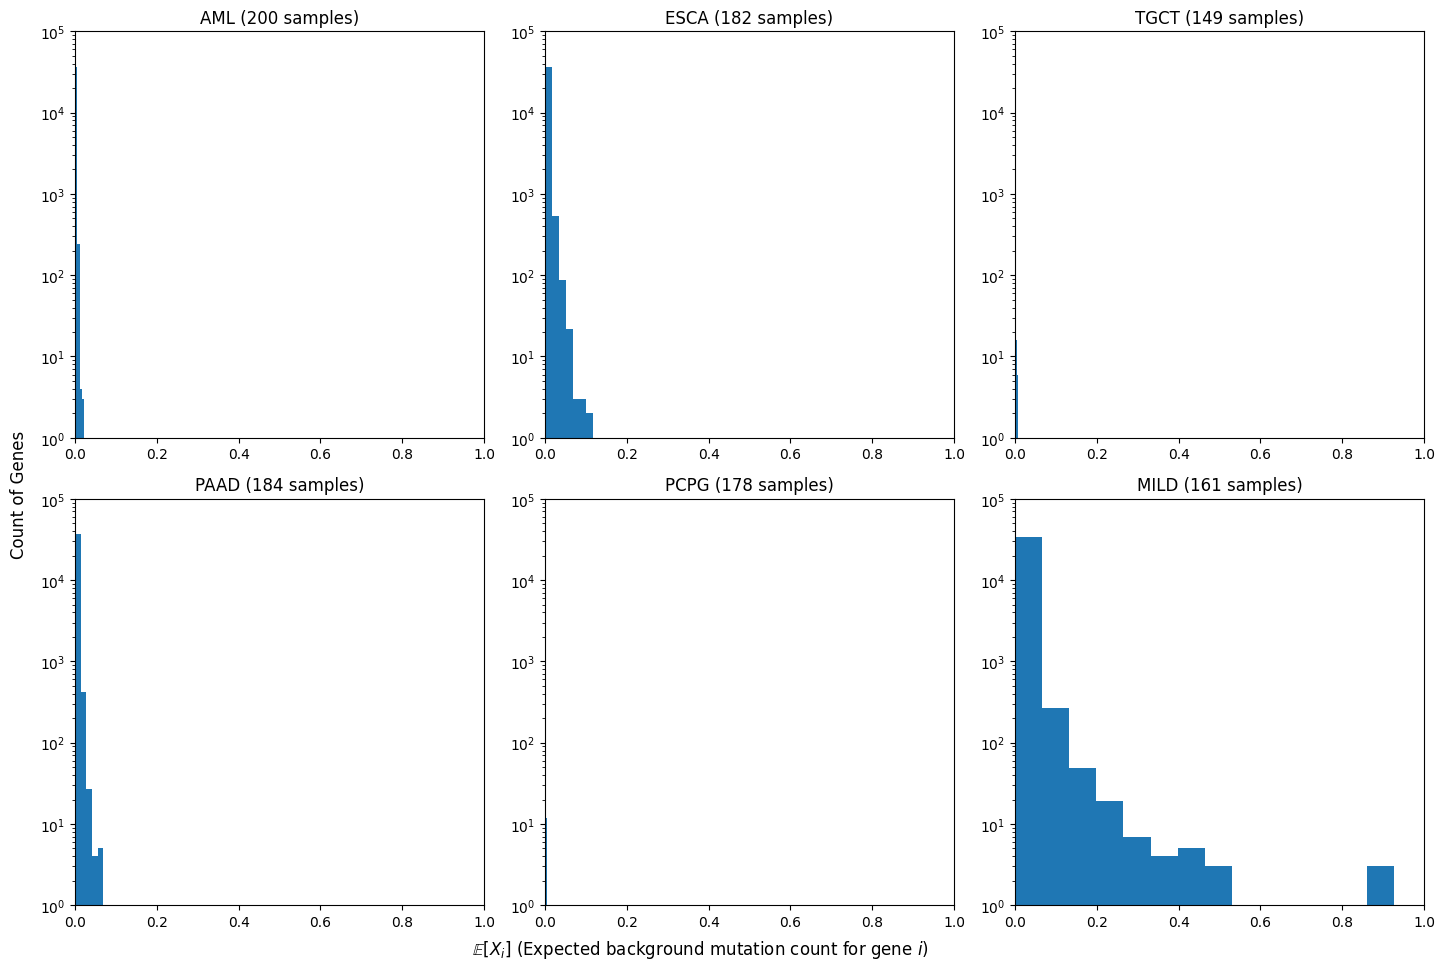

In [29]:
# MILD vs. AML (200) vs. ESCA (182) vs. TGCT (149) vs. PAAD (184) vs. PCPG (178)

cancer_subtypes = ['AML', 'ESCA', 'TGCT', 'PAAD', 'PCPG', 'MILD']
num_samples = [200, 182, 149, 184, 178, 161]


BASE_RES_DIR = '/Users/work/workspace/research/dialect/results/'
TCGA_RES_DIR = os.path.join(BASE_RES_DIR, 'tcga_pancan_atlas_2018')
GDAN_RES_DIR = os.path.join(BASE_RES_DIR, 'gdan_2024')

TCGA_BMR_BASE_FN = os.path.join(TCGA_RES_DIR, '{}/{}_cbase_bmr_pmfs.csv')
GDAN_BMR_BASE_FN = os.path.join(GDAN_RES_DIR, '{}/{}_cbase_bmr_pmfs.csv')

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, subtype in enumerate(cancer_subtypes):
    if subtype == 'MILD':
        bmr_fn = GDAN_BMR_BASE_FN.format(subtype, subtype)
    else:
        bmr_fn = TCGA_BMR_BASE_FN.format(subtype, subtype)
    counts = compute_expected_background_counts(bmr_fn)
    
    # Plot histogram in the respective subplot
    axes[i].hist(counts, bins=25, log=True)
    axes[i].set_ylim(1, 10e4)
    axes[i].set_xlim(0, 1)
    axes[i].set_title('{} ({} samples)'.format(subtype, num_samples[i]))

# Add common x-axis and y-axis labels
fig.text(0.5, 0.04, r'$\mathbb{E}[X_i]$ (Expected background mutation count for gene $i$)', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Count of Genes', va='center', rotation='vertical', fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()

## RES-43: Dialect Significance Testing

In [11]:
cnt_mtx_fn = os.path.join(RESULTS_DIR, f"{SUBTYPE}_cbase_cnt_mtx.csv")
bmr_pmfs_fn = os.path.join(RESULTS_DIR, f"{SUBTYPE}_cbase_bmr_pmfs.csv")
cnt_mtx_df = pd.read_csv(cnt_mtx_fn, index_col=0)
bmr_pmfs_df = pd.read_csv(bmr_pmfs_fn, index_col=0)
bmrs_pmfs_dict = bmr_pmfs_df.T.to_dict(orient="list")
bmrs_pmfs_dict = {
    key: [x for x in bmrs_pmfs_dict[key] if not np.isnan(x)] for key in bmrs_pmfs_dict
}

In [46]:
def dialect_pairwise_v2(gene_a_mutations, gene_b_mutations, gene_a_bmr_pmfs, gene_b_bmr_pmfs,):
    tau_init = (0.1, 0.1, 0.1, 0.7)
    ga_bg = np.array([gene_a_bmr_pmfs[c_i] if c_i < len(gene_a_bmr_pmfs) else 0 for c_i in gene_a_mutations])
    ga_dv = np.array([gene_a_bmr_pmfs[c_i - 1] if 0 < c_i < len(gene_a_bmr_pmfs) else 0 for c_i in gene_a_mutations])
    gb_bg = np.array([gene_b_bmr_pmfs[c_i] if c_i < len(gene_b_bmr_pmfs) else 0 for c_i in gene_b_mutations])
    gb_dv = np.array([gene_b_bmr_pmfs[c_i - 1] if 0 < c_i < len(gene_b_bmr_pmfs) else 0 for c_i in gene_b_mutations])

    tau_00, tau_01, tau_10, tau_11 = em_pair(tau_init, ga_bg, gb_bg, ga_dv, gb_dv)
    ll_hat = log_likelihood_pair(tau_00, tau_01, tau_10, tau_11, ga_bg, gb_bg, ga_dv, gb_dv)
    tau_1X = tau_10 + tau_11
    tau_X1 = tau_01 + tau_11
    tau_11_null = tau_1X * tau_X1
    ll_null = log_likelihood_pair((1 - tau_11_null - tau_01 - tau_10), tau_01, tau_10, tau_11_null, ga_bg, gb_bg, ga_dv, gb_dv)

    ll_ratio = -2 * (ll_null - ll_hat)
    log_odds, std_err = calculate_log_odds_and_std_err(np.array([tau_00, tau_01, tau_10, tau_11]), len(gene_a_somatic_mutations))
    return (tau_00, tau_01, tau_10, tau_11), ll_ratio, log_odds, std_err

In [88]:
def run_single_pair_dialect_v2(gene_a_bmr_pmfs, gene_b_bmr_pmfs, gene_a_mutations, gene_b_mutations):
    taus, llr, log_odds_ratio, std_err = dialect_pairwise_v2(gene_a_mutations, gene_b_mutations, gene_a_bmr_pmfs, gene_b_bmr_pmfs)
    llr_corrected = llr
    llr_p = 1 - stats.chi2.cdf(llr_corrected, 1)
    wald = log_odds_ratio / std_err
    wald_p = 1 - stats.norm.cdf(wald)
    return llr_p, wald_p

In [172]:
# SHARED PARAMETERS
tau_11 = 0 # no co-occurring drivers at all
nruns = 1000
nsamples = 2000

lowest_bmr_gene = 'HBA1_N'
highest_bmr_gene = 'TTN_M'

gene_a, gene_b, gene_c, gene_d = "GENE_A", "GENE_B", "GENE_C", "GENE_D"
gene_a_bmr_pmfs = np.array(bmrs_pmfs_dict[lowest_bmr_gene]) # driver
gene_b_bmr_pmfs = np.array(bmrs_pmfs_dict[highest_bmr_gene]) # driver
gene_c_bmr_pmfs = np.array(bmrs_pmfs_dict[lowest_bmr_gene]) # driver
gene_d_bmr_pmfs = np.array(bmrs_pmfs_dict[highest_bmr_gene]) # passenger 
gene_a_bmr_pmfs = gene_a_bmr_pmfs / sum(gene_a_bmr_pmfs)
gene_b_bmr_pmfs = gene_b_bmr_pmfs / sum(gene_b_bmr_pmfs)
gene_c_bmr_pmfs = gene_c_bmr_pmfs / sum(gene_c_bmr_pmfs)
gene_d_bmr_pmfs = gene_d_bmr_pmfs / sum(gene_d_bmr_pmfs)
co_tau_10 = 0.1
me_tau_10, me_tau_01 = 0.10, 0.10
positive_fisher_results, positive_dialect_results = [], []
negative_fisher_results, negative_dialect_results = [], []

for run in tqdm(range(nruns)):
    gene_a_passenger_mutations = np.random.choice(len(gene_a_bmr_pmfs), nsamples, p=gene_a_bmr_pmfs)
    gene_b_passenger_mutations = np.random.choice(len(gene_b_bmr_pmfs), nsamples, p=gene_b_bmr_pmfs)
    gene_c_passenger_mutations = np.random.choice(len(gene_c_bmr_pmfs), nsamples, p=gene_c_bmr_pmfs)
    gene_d_passenger_mutations = np.random.choice(len(gene_d_bmr_pmfs), nsamples, p=gene_d_bmr_pmfs)
    gene_a_driver_mutations, gene_b_driver_mutations = generate_pairwise_driver_mutations(
        nsamples, me_tau_10, me_tau_01, tau_11
    )
    gene_c_driver_mutations = np.random.choice([0, 1], nsamples, p=[1 - co_tau_10, co_tau_10])
    gene_a_somatic_mutations = (gene_a_passenger_mutations + gene_a_driver_mutations).astype(int)
    gene_b_somatic_mutations = (gene_b_passenger_mutations + gene_b_driver_mutations).astype(int)
    gene_c_somatic_mutations = (gene_c_passenger_mutations + gene_c_driver_mutations).astype(int)
    gene_d_somatic_mutations = gene_d_passenger_mutations.astype(int)
    gene_a_binarized_mutations = np.array([1 if x > 0 else 0 for x in gene_a_somatic_mutations])
    gene_b_binarized_mutations = np.array([1 if x > 0 else 0 for x in gene_b_somatic_mutations])
    gene_c_binarized_mutations = np.array([1 if x > 0 else 0 for x in gene_c_somatic_mutations])
    gene_d_binarized_mutations = np.array([1 if x > 0 else 0 for x in gene_d_somatic_mutations])
    contingency_table_ab = confusion_matrix(gene_a_binarized_mutations, gene_b_binarized_mutations, labels=[1,0])
    contingency_table_cd = confusion_matrix(gene_c_binarized_mutations, gene_d_binarized_mutations, labels=[1,0])

    positive_fishers_result = stats.fisher_exact(contingency_table_ab, alternative='less')[1]
    negative_fishers_result = stats.fisher_exact(contingency_table_cd, alternative='less')[1]
    positive_dialect_result = run_single_pair_dialect_v2(gene_a_bmr_pmfs, gene_b_bmr_pmfs, gene_a_somatic_mutations, gene_b_somatic_mutations)
    negative_dialect_result = run_single_pair_dialect_v2(gene_c_bmr_pmfs, gene_d_bmr_pmfs, gene_c_somatic_mutations, gene_d_somatic_mutations)

    positive_fisher_results.append(positive_fishers_result)
    negative_fisher_results.append(negative_fishers_result)
    positive_dialect_results.append(positive_dialect_result)
    negative_dialect_results.append(negative_dialect_result)

100%|██████████| 1000/1000 [00:09<00:00, 105.67it/s]


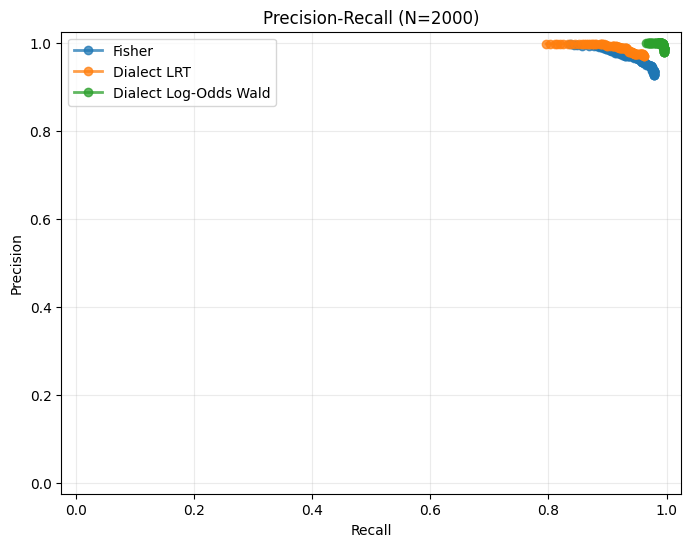

In [173]:
import numpy as np
import matplotlib.pyplot as plt

# Varying alpha values
a_values = np.linspace(0.01, 0.1, 100)

# Initialize lists to store precision and recall values
fisher_precisions, fisher_recalls = [], []
dialect_llr_precisions, dialect_llr_recalls = [], []
dialect_wald_precisions, dialect_wald_recalls = [], []

# Loop over different alpha values to compute precision and recall
for alpha in a_values:
    # Fisher
    fisher_tp = sum(np.array(positive_fisher_results) < alpha)
    fisher_fp = sum(np.array(negative_fisher_results) < alpha)
    fisher_fn = len(positive_fisher_results) - fisher_tp
    fisher_precision = fisher_tp / (fisher_tp + fisher_fp) if (fisher_tp + fisher_fp) > 0 else 0
    fisher_recall = fisher_tp / (fisher_tp + fisher_fn) if (fisher_tp + fisher_fn) > 0 else 0
    fisher_precisions.append(fisher_precision)
    fisher_recalls.append(fisher_recall)
    
    # Dialect LLR
    dialect_llr_tp = sum(np.array([x[0] for x in positive_dialect_results]) < alpha)
    dialect_llr_fp = sum(np.array([x[0] for x in negative_dialect_results]) < alpha)
    dialect_llr_fn = len(positive_dialect_results) - dialect_llr_tp
    dialect_llr_precision = dialect_llr_tp / (dialect_llr_tp + dialect_llr_fp) if (dialect_llr_tp + dialect_llr_fp) > 0 else 0
    dialect_llr_recall = dialect_llr_tp / (dialect_llr_tp + dialect_llr_fn) if (dialect_llr_tp + dialect_llr_fn) > 0 else 0
    dialect_llr_precisions.append(dialect_llr_precision)
    dialect_llr_recalls.append(dialect_llr_recall)
    
    # Dialect Wald
    dialect_wald_tp = sum(np.array([x[1] for x in positive_dialect_results]) < alpha)
    dialect_wald_fp = sum(np.array([x[1] for x in negative_dialect_results]) < alpha)
    dialect_wald_fn = len(positive_dialect_results) - dialect_wald_tp
    dialect_wald_precision = dialect_wald_tp / (dialect_wald_tp + dialect_wald_fp) if (dialect_wald_tp + dialect_wald_fp) > 0 else 0
    dialect_wald_recall = dialect_wald_tp / (dialect_wald_tp + dialect_wald_fn) if (dialect_wald_tp + dialect_wald_fn) > 0 else 0
    dialect_wald_precisions.append(dialect_wald_precision)
    dialect_wald_recalls.append(dialect_wald_recall)

# Plotting the precision-recall curves
plt.figure(figsize=(8, 6))

# Fisher precision-recall curve
plt.plot(fisher_recalls, fisher_precisions, label='Fisher', marker='o', linestyle='-', linewidth=2, alpha=0.75)

# Dialect LLR precision-recall curve
plt.plot(dialect_llr_recalls, dialect_llr_precisions, label='Dialect LRT', marker='o', linestyle='-', linewidth=2, alpha=0.75)

# Dialect Wald precision-recall curve
plt.plot(dialect_wald_recalls, dialect_wald_precisions, label='Dialect Log-Odds Wald', marker='o', linestyle='-', linewidth=2,alpha=0.75)

plt.ylim(-0.025, 1.025)
plt.xlim(-0.025, 1.025)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (N={})'.format(nsamples))
plt.legend()
plt.grid(True, alpha=0.25)
plt.show()
